# Lab4 Textual Data

## 1. Find the top 10 word bigram from UN General Debates of years 1970 – 1990 and compare with those of years 1990 – the latest (remove stopwords first)

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
df = pd.read_csv('un-general-debates-blueprint.csv.gz')

df

,session,year,country,country_name,speaker,position,text
0,25,1970,ALB,Albania,Mr. NAS,NaN,33: May I first convey to our President the co...
1,25,1970,ARG,Argentina,Mr. DE PABLO PARDO,NaN,177.\t : It is a fortunate coincidence that pr...
2,25,1970,AUS,Australia,Mr. McMAHON,NaN,100.\t It is a pleasure for me to extend to y...
3,25,1970,AUT,Austria,Mr. KIRCHSCHLAEGER,NaN,155.\t May I begin by expressing to Ambassado...
4,25,1970,BEL,Belgium,Mr. HARMEL,NaN,"176. No doubt each of us, before coming up to ..."
...,...,...,...,...,...,...,...
7502,70,2015,YEM,Yemen,Mr. Abdrabuh Mansour Hadi Mansour,President,On behalf of the people and the Government of ...
7503,70,2015,YUG,Yugoslavia,Mr. Tomislav Nikolić,President,\nSeventy years have passed since the establis...
7504,70,2015,ZAF,South Africa,Jacob Zuma,President,I should like to congratulate the President an...
7505,70,2015,ZMB,Zambia,Mr. Edgar Chagwa Lungu,President,I would like to begin by thanking the Secretar...


In [1]:
# Tokenization
import regex as re
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

# Stopword Removal
import nltk
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

pipeline = [str.lower, tokenize, remove_stop, ngrams]
def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

from collections import Counter

def count_words(df, column='tokens', preprocess=None, min_freq = 2):
    
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    
    # create counter and run through all data
    counter = Counter()
    df[column].map(update)
    
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq > @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

NameError: name 'ngrams' is not defined

In [49]:
df['tokens']= df['text'].apply(prepare,pipeline=pipeline)
df['bigram'] = df['tokens'].apply(ngrams)

In [50]:
x = df[df['year']<=1990]
freq_df = count_words(x,column='bigram')
freq_df.head(10)

,freq
token,
united nations,43846
general assembly,13915
developing countries,11991
international community,11506
south africa,9300
united states,7718
middle east,7608
security council,7500
peace security,6755


In [51]:
y = df[df['year']>1990]
freq = count_words(y,column='bigram')
freq.head(10)

,freq
token,
united nations,59398
international community,16280
security council,13472
human rights,13295
general assembly,13186
peace security,8466
developing countries,6527
member states,5941
sustainable development,5258


## 2. Create a bigram word cloud of the UN General Debates dataset of years 1970 – 1990 and 1990 to the latest (remove stopwords first)

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [53]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

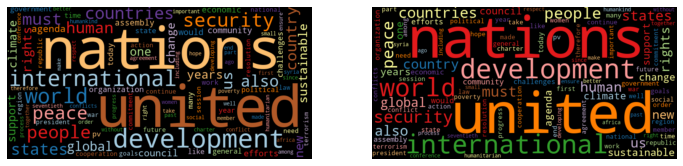

In [54]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)###
wordcloud(freq_2015_df['freq'], max_words=100)
plt.subplot(1,2,2)###
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)
#plt.tight_layout()###

## 3. Create a trend graph showing the bigram and word trend of “climate change”,“global warming”,“wars” and 3 others of your choices

In [55]:
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
           if len([t for t in ngram if t in stopwords])==0]

In [56]:
text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens,2, stopwords=stopwords)))

visible manifestation|global climate|climate change


In [30]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [31]:
keywords = ['climate change','global warming','wars','new','states','development']

print(count_keywords(tokens, keywords))

[0, 0, 0, 0, 0, 0]


In [33]:
def count_keywords_by(df, by, keywords, column='tokens'):
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by]
    
    return freq_df.groupby(by).sum().sort_values(by)

In [45]:
A = ['wars','new','states','development']
B = ['climate change','global warming']
freq_df_A = count_keywords_by(df, by='year', keywords=A, column = 'tokens')
freq_df_B = count_keywords_by(df, by='year', keywords=B, column = 'bigram')

<AxesSubplot:xlabel='year'>

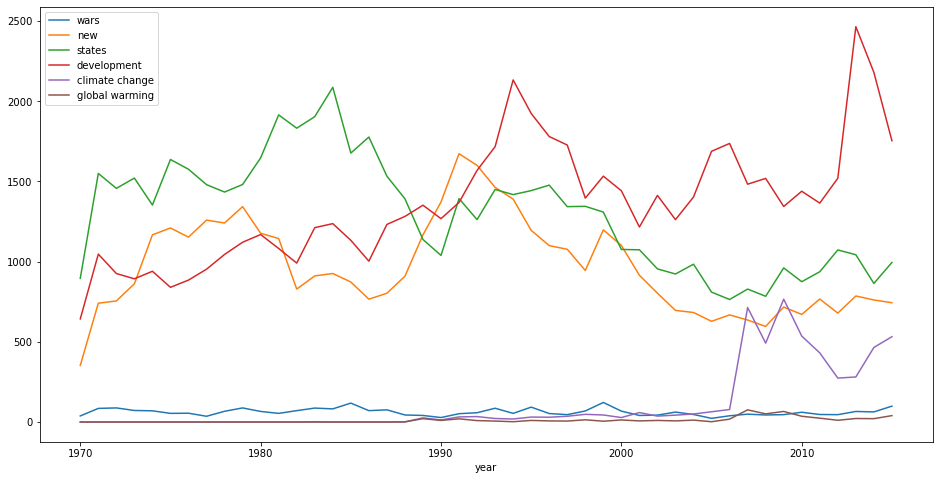

In [46]:
ax = freq_df_A.plot(kind='line', figsize=(16,8))
freq_df_B.plot(ax=ax)
